#  Customer Retention: Equity Investment

### Business goal:
In order to imporove user retention and lower churn, company is interested in understanding why and which users withdraw money from thier account.

### Data:
Anomalized real data from financial service company.

### Instruction for running this code:
Python version: 3.6.1<br>
Jupyter Notebook version: 4.3.0<br>
Required python packages and versions:<br>
seaborn==0.7.1<br>
scikit-learn==0.21.3<br>
pandas==0.20.1<br>
numpy==1.17.2<br>
matplotlib==2.0.2<br>
imblearn==0.0<br>


Author:

Yu-Cian Hong

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# training algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# training data prep
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# performace metrics
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# jupyter notebook display settting
pd.set_option('display.max_colwidth', -1)

from IPython.display import Markdown, display
 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"    

import warnings
warnings.filterwarnings('ignore')

# Data summary 

In [3]:
# load data
df = pd.read_csv('features_data.csv')
df2 = pd.read_csv('equity_value_data.csv')

In [4]:
df.head(5)

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [5]:
df2.head(5)

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [15]:
print 'number of customers in customer features data (features_data.csv):',df.user_id.nunique(),'\n'
print 'data features:','\n'
df.info()


number of customers in customer features data (features_data.csv): 5584 

data features: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
risk_tolerance                  5584 non-null object
investment_experience           5584 non-null object
liquidity_needs                 5584 non-null object
platform                        5584 non-null object
time_spent                      5584 non-null float64
instrument_type_first_traded    5584 non-null object
first_deposit_amount            5584 non-null float64
time_horizon                    5584 non-null object
user_id                         5584 non-null object
dtypes: float64(2), object(7)
memory usage: 392.7+ KB


In [16]:
print "number of customers in equity value data (equity_value_data.csv):", df2.user_id.nunique(),'\n'

print 'data features:','\n'


df2.info()

number of customers in equity value data (equity_value_data.csv): 5584 

data features: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
timestamp       1119158 non-null object
close_equity    1119158 non-null float64
user_id         1119158 non-null object
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


In [31]:
# transform timestamp to datetime format
df2['timestamp']=pd.to_datetime(df2['timestamp'])

print "data collection period:", df2['timestamp'].dt.date.min(),' -> ', df2['timestamp'].dt.date.max()


data collection period: 2016-08-16  ->  2017-08-18


# Analysis of churned user :
percentage of churned user: 4.19 %

In [32]:
# compute time difference between consecutive rows in timestamp column
time_next = df2.timestamp[1:]
time_next.reset_index(inplace=True, drop=True)
id2 = df2.user_id[1:]
id2.reset_index(inplace=True, drop=True)
df2['time_next'] = time_next
df2['id2'] = id2
df2 = df2[:-1]
df2_tmp = df2[df2.user_id==df2.id2]
df2_2 = df2_tmp[['timestamp','time_next']] 

# compute time difference
f = lambda x: len(pd.bdate_range(x['timestamp'], x['time_next']))
diff = df2_2.apply(f, axis=1)

In [35]:
# offset time difference by -1 day
df2['diff']=diff-1

### ratio of churned customers:

In [37]:
# longest inactive period of each user
max_inactive = df2.groupby('user_id').agg({'diff':'max'})

# longest inactive period of churned user
churned_tmp = max_inactive[max_inactive>=28].dropna()
print("Ratio of churned customers:")
print("%4.2f" %(float(churned_tmp.shape[0])/max_inactive.shape[0]*100.)+'%')
print("==> Data imbalance")

Ratio of churned customers:
4.19%
==> Data imbalance


## analyze churned customers:

In [75]:
print("Insight: churned customers tend to have higher risk tolerance and limited or no investment experiences.")
# create dataframe for churned customers
churned_pp_id = list(churned_tmp.index)
df_churned = df[df['user_id'].isin(churned_pp_id)]

print("\nrisk tolerance vs. num of churned customers:")
df_churned.risk_tolerance.value_counts()
print("\ninvestment experience vs. num of churned customers:")
df_churned.investment_experience.value_counts()
print("\ntime horizon vs. num of churned customers:")
df_churned.time_horizon.value_counts()



Insight: churned customers tend to have higher risk tolerance and limited or no investment experiences.

risk tolerance vs. num of churned customers:


high_risk_tolerance    116
med_risk_tolerance     94 
low_risk_tolerance     24 
Name: risk_tolerance, dtype: int64


investment experience vs. num of churned customers:


limited_investment_exp      112
no_investment_exp           78 
good_investment_exp         42 
extensive_investment_exp    2  
Name: investment_experience, dtype: int64


time horizon vs. num of churned customers:


short_time_horizon    131
long_time_horizon     73 
med_time_horizon      30 
Name: time_horizon, dtype: int64

In [140]:
# combine longest inactive period of user to customer fearures dataframe
max_days = pd.Series(list(max_inactive['diff']))
ind = pd.Series(list(max_inactive.index))
df_max_inactive = pd.DataFrame({'user_id':ind,'max_inactive_days':max_days})

df_merge = pd.merge(df, df_max_inactive, on='user_id')

In [141]:
df_merge.head(10)

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,max_inactive_days
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,2.0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,2.0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,2.0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,2.0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,2.0
5,med_risk_tolerance,no_investment_exp,not_important_liq_need,iOS,12.968117,stock,100.0,med_time_horizon,0322b1d744cc89ebbe6ebe70d824d922,6.0
6,low_risk_tolerance,good_investment_exp,very_important_liq_need,Android,30.710083,stock,5.0,long_time_horizon,f4cac8c1544b723ddedc9bdba81c64c0,24.0
7,high_risk_tolerance,good_investment_exp,somewhat_important_liq_need,iOS,0.000000,stock,100.0,short_time_horizon,bdc39d2fc664ef9a5e6713168057f892,2.0
8,high_risk_tolerance,good_investment_exp,very_important_liq_need,iOS,0.000000,stock,5000.0,short_time_horizon,85f2f0f54411b4f3e7a403ba902e7280,2.0
9,med_risk_tolerance,no_investment_exp,very_important_liq_need,Android,2.969617,stock,11.0,med_time_horizon,529ddd19dac72d55cde8e633340a9aed,2.0


## Feature engineering:
reformat features for training classifiers

In [142]:
# users who churned are labeled as 1, otherwise 0
df_merge['churned'] = False
df_merge.loc[df_merge.max_inactive_days>=28,'churned'] = True
df_merge['churned'] = df_merge['churned'].astype(int)

# translate ordinal columns to numerical value:
print("original ordinal features:")
list(df_merge.risk_tolerance.unique())
list(df_merge.investment_experience.unique())
list(df_merge.liquidity_needs.unique())
list(df_merge.time_horizon.unique())

df_merge.loc[df_merge['risk_tolerance']=='high_risk_tolerance','risk_tolerance'] = 1.
df_merge.loc[df_merge['risk_tolerance']=='med_risk_tolerance','risk_tolerance'] = 0.5
df_merge.loc[df_merge['risk_tolerance']=='low_risk_tolerance','risk_tolerance'] = 0.

df_merge.loc[df_merge['investment_experience']=='extensive_investment_exp','investment_experience'] = 1.
df_merge.loc[df_merge['investment_experience']=='good_investment_exp','investment_experience'] = .66
df_merge.loc[df_merge['investment_experience']=='limited_investment_exp','investment_experience'] = .33
df_merge.loc[df_merge['investment_experience']=='no_investment_exp','investment_experience'] = 0.


df_merge.loc[df_merge['liquidity_needs']=='very_important_liq_need','liquidity_needs'] = 1.
df_merge.loc[df_merge['liquidity_needs']=='somewhat_important_liq_need','liquidity_needs'] = .5
df_merge.loc[df_merge['liquidity_needs']=='not_important_liq_need','liquidity_needs'] = 0.


df_merge.loc[df_merge['time_horizon']=='long_time_horizon','time_horizon'] = 1.
df_merge.loc[df_merge['time_horizon']=='med_time_horizon','time_horizon'] = 0.5
df_merge.loc[df_merge['time_horizon']=='short_time_horizon','time_horizon'] = 0.

# rescale numerical columns
df_merge.time_spent = StandardScaler().fit_transform(df_merge.time_spent.values.reshape(-1, 1)).astype(int)
df_merge.first_deposit_amount = StandardScaler().fit_transform(df_merge.first_deposit_amount.values.reshape(-1, 1)).astype(int)

# one hot encode categorical columns:
print("\noriginal categorical features:")
list(df_merge.platform.unique())
list(df_merge.instrument_type_first_traded.unique())
tmp1 = pd.get_dummies(df_merge[['platform','instrument_type_first_traded']])
df3 = pd.concat([df_merge,tmp1], axis=1)
df3 = df3.drop(['platform','instrument_type_first_traded','max_inactive_days','user_id'],axis = 1)

print("\nnew features: ordinal -> numerical, catergorical-> one-hot encoded")
list(df3.columns)

original ordinal features:


['high_risk_tolerance', 'med_risk_tolerance', 'low_risk_tolerance']

['limited_investment_exp',
 'no_investment_exp',
 'good_investment_exp',
 'extensive_investment_exp']

['very_important_liq_need',
 'not_important_liq_need',
 'somewhat_important_liq_need']

['med_time_horizon', 'short_time_horizon', 'long_time_horizon']


original categorical features:


['Android', 'iOS', 'both']

['stock',
 'etp',
 'adr',
 'wrt',
 'mlp',
 '0',
 'lp',
 'rlt',
 'reit',
 'cef',
 'tracking']


new features: ordinal -> numerical, catergorical-> one-hot encoded


['risk_tolerance',
 'investment_experience',
 'liquidity_needs',
 'time_spent',
 'first_deposit_amount',
 'time_horizon',
 'churned',
 'platform_Android',
 'platform_both',
 'platform_iOS',
 'instrument_type_first_traded_0',
 'instrument_type_first_traded_adr',
 'instrument_type_first_traded_cef',
 'instrument_type_first_traded_etp',
 'instrument_type_first_traded_lp',
 'instrument_type_first_traded_mlp',
 'instrument_type_first_traded_reit',
 'instrument_type_first_traded_rlt',
 'instrument_type_first_traded_stock',
 'instrument_type_first_traded_tracking',
 'instrument_type_first_traded_wrt']

## Data correlations:
meaningful insight: <br><br>User churn has a somwhat significant correlation with risk tolerance. More over, risk tolerance, investment experience, and time horizon have cross corrleations.
They turned out to be the top features used by random forest. Another set of notable correlations are between instrument type etp
/ stock and investment experience.   <br><br>
Other interesting insights include highly positive correlations
between android users and liquidity needs, and highly negative correlations between iOS users and liquidity needs. Correlations between platform and instrument are purely due to their mutually exclusive nature.



**correlation between data columns:**


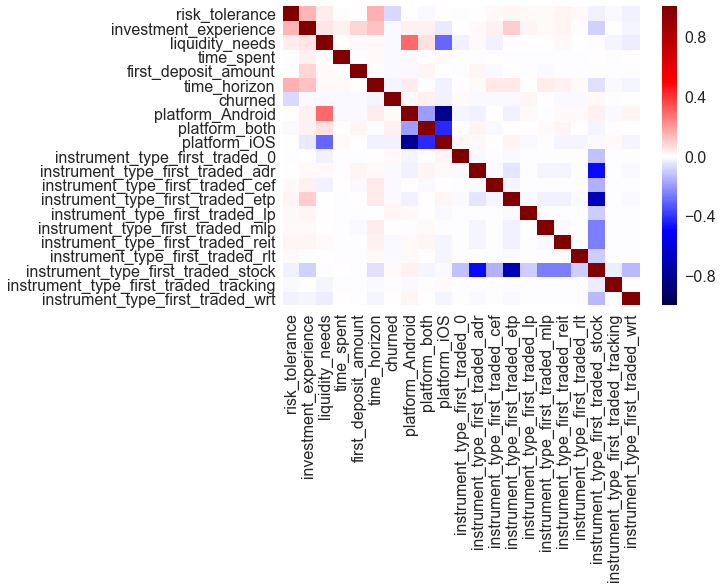

,time_spent,first_deposit_amount,churned,platform_Android,platform_both,platform_iOS,instrument_type_first_traded_0,instrument_type_first_traded_adr,instrument_type_first_traded_cef,instrument_type_first_traded_etp,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt
time_spent,1.000000,-0.001856,-0.009132,-0.012241,0.000229,0.011206,-0.003200,-0.007539,0.002365,-0.000753,-0.002509,-0.002774,-0.000857,-0.002662,0.005777,-0.000887,0.003531
first_deposit_amount,-0.001856,1.000000,-0.012133,-0.012752,0.018221,0.000956,-0.002576,0.019453,-0.008256,0.006932,-0.005216,-0.013734,-0.005778,-0.005533,-0.005720,-0.001843,-0.007382
churned,-0.009132,-0.012133,1.000000,0.007870,0.027540,-0.023707,0.008442,-0.010926,-0.012539,-0.010784,0.015708,0.006292,-0.011809,-0.008403,0.014940,-0.002799,0.005510
platform_Android,-0.012241,-0.012752,0.007870,1.000000,-0.193627,-0.811236,-0.021330,-0.023820,0.003520,-0.028398,0.008595,-0.004311,0.011956,0.015374,0.028485,-0.008218,0.019677
platform_both,0.000229,0.018221,0.027540,-0.193627,1.000000,-0.416577,-0.002276,0.017545,-0.008453,0.005837,0.004565,0.012810,0.019132,0.002896,-0.022871,-0.004220,0.006460
platform_iOS,0.011206,0.000956,-0.023707,-0.811236,-0.416577,1.000000,0.021122,0.011616,0.001776,0.022836,-0.010685,-0.003640,-0.022482,-0.015972,-0.012764,0.010130,-0.022084
instrument_type_first_traded_0,-0.003200,-0.002576,0.008442,-0.021330,-0.002276,0.021122,1.000000,-0.009238,-0.002896,-0.013109,-0.001830,-0.004818,-0.004818,-0.001941,-0.121982,-0.000647,-0.002589
instrument_type_first_traded_adr,-0.007539,0.019453,-0.010926,-0.023820,0.017545,0.011616,-0.009238,1.000000,-0.011465,-0.051894,-0.007243,-0.019073,-0.019073,-0.007683,-0.482892,-0.002559,-0.010251
instrument_type_first_traded_cef,0.002365,-0.008256,-0.012539,0.003520,-0.008453,0.001776,-0.002896,-0.011465,1.000000,-0.016270,-0.002271,-0.005980,-0.005980,-0.002409,-0.151395,-0.000802,-0.003214
instrument_type_first_traded_etp,-0.000753,0.006932,-0.010784,-0.028398,0.005837,0.022836,-0.013109,-0.051894,-0.016270,1.000000,-0.010279,-0.027065,-0.027065,-0.010903,-0.685246,-0.003632,-0.014547


In [60]:
print("**correlation between data columns:**")
sns.set(font_scale=1.6)
a = sns.heatmap(data=df3.astype(float).corr(), cmap="seismic", annot=False)
plt.show();

# correlation table
df3.corr()

In [58]:
# function to plot confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=40)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=36)
    plt.yticks(tick_marks, classes, fontsize=36)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True class', fontsize=40)
    plt.xlabel('Predicted class', fontsize=40)

    return plt



# function to get model performance metrics
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted)             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted)
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted)
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

## Imbalanced dataset : upsamplindaatg
data of churned users (4%) are upsampled to match with data of users who didn't churn

In [111]:
import random
ran_number = int(random.uniform(1, 300))

df3_f = resample(df3[df3.churned==1],
                 replace=True, # sample with replacement
                 n_samples=df3[df3.churned==0].shape[0], # match number in majority class
                 random_state=12) # reproducible results
df3_n= df3[df3.churned==0]
df3_up = pd.concat([df3_f,df3_n])
del df3_n,df3_f
print "total number of upsampled data entries:",df3_up.shape[0]

total number of upsampled data entries: 10700


# Model training

## 1. Random Forest Classifier 
The classifier predicts the probability that a user will churn based on their features.
Random forest classifier is selected upon first approaching the problem, because tree methods are intrinsically good at selecting best features.  All features are used in the model training.


In [112]:
# split labeled data into training, validation, and test set (0.6,0.2,0.2)
X_traintmp, X_test, y_traintmp, y_test = train_test_split(df3_up.drop('churned',axis=1), df3_up.churned, test_size=0.2, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_traintmp,y_traintmp, test_size=0.2, random_state=20)

In [113]:
# random forest classifier
# manual random grid search for hyperparameter tuning 
rfmodel2 = RandomForestClassifier(bootstrap= True,n_estimators=20,min_samples_leaf=2,min_samples_split=5,
                                 max_depth= 10,random_state=54,n_jobs=-1)

# training model
r = rfmodel2.fit(X_train, y_train)

# on validation data: predict probability of user churn and classify user
y_predicted = rfmodel2.predict(X_val)

### important metric: recall
The most important model metrics is the recall score or true positive rate. It tells how much of the churned users
are correctly classified as churned. 
<br><br>Ideally, we want to prevent most users from churning with the model, so the ability of the model
to identify as many users who will churn is most critical. The model is thus tuned according to the best recall score, which is listed below. 

In [114]:
print("random forest performance on validation set (for hyperparameter tuning):\n")

cm = confusion_matrix(y_val, y_predicted, labels = [0,1])
tp = cm[0][0]
fn = cm [0][1]
fp = cm [1][0]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
print ("precision= %4.2f, recall= %4.2f "%(precision, recall))

random forest performance on validation set (for hyperparameter tuning):

precision= 0.63, recall= 0.65 


### ROC curve

AUC score:  0.77 



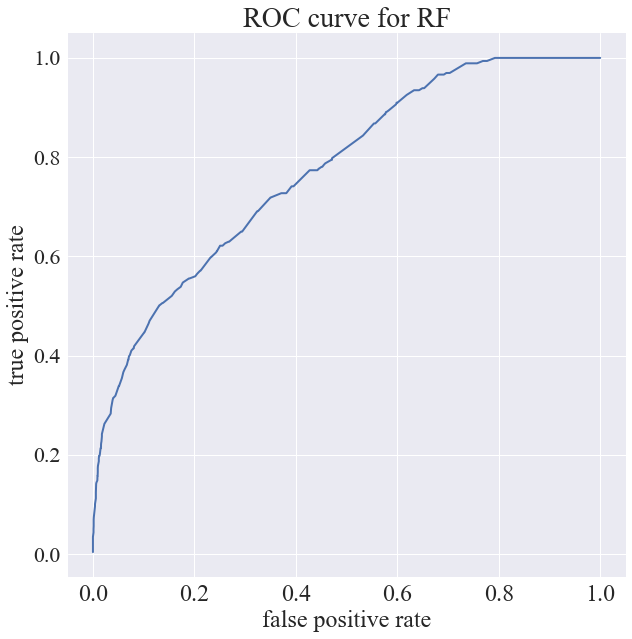

In [115]:
probabilities = (rfmodel2.predict_proba(X_train))

print "AUC score: %5.2f"%roc_auc_score(y_train, probabilities[:, 1]),'\n'
fpr, tpr, threshold = metrics.roc_curve(y_train, probabilities[:, 1])
roc_auc = metrics.auc(fpr, tpr)
f = plt.figure(figsize=(10,10))
p = plt.plot(fpr, tpr,linewidth=2.0)
t = plt.title('ROC curve for RF',fontname = "Times New Roman",fontsize=28)
x = plt.xlabel('false positive rate',fontname = "Times New Roman",fontsize=24)
y = plt.ylabel('true positive rate',fontname = "Times New Roman",fontsize=24)
xi = plt.xticks(fontname = "Times New Roman",fontsize=24)  
yi = plt.yticks(fontname = "Times New Roman",fontsize=22)  


plt.show()

# Important features

In [118]:
# get important features of the RF classifier
importances = rfmodel2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfmodel2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

df_rf = pd.DataFrame({'indices':indices, 'importance':importances[indices]})
features = list(df3.drop('churned',axis=1).columns)
indices = list(df_rf.indices)

features_sorted = []
for ind in indices:
    features_sorted.append(features[ind])

df_rf['feature'] = features_sorted

print("**top 10 features of the Random Forest classifier:**")
df_rf.drop(['importance','indices'],axis=1).head(10)
print("\nTop 2 features of RF classifier in the upsampled data are:\ninvestment experience and risk tolerance, which\
 has great correspondance with previous analysis.")

**top 10 features of the Random Forest classifier:**


,feature
0,risk_tolerance
1,investment_experience
2,first_deposit_amount
3,time_horizon
4,liquidity_needs
5,time_spent
6,platform_iOS
7,instrument_type_first_traded_etp
8,platform_both
9,platform_Android



Top 2 features of RF classifier in the upsampled data are:
investment experience and risk tolerance, which has great correspondance with previous analysis.


random forest performance on test set:


precision= 0.68, recall= 0.67  



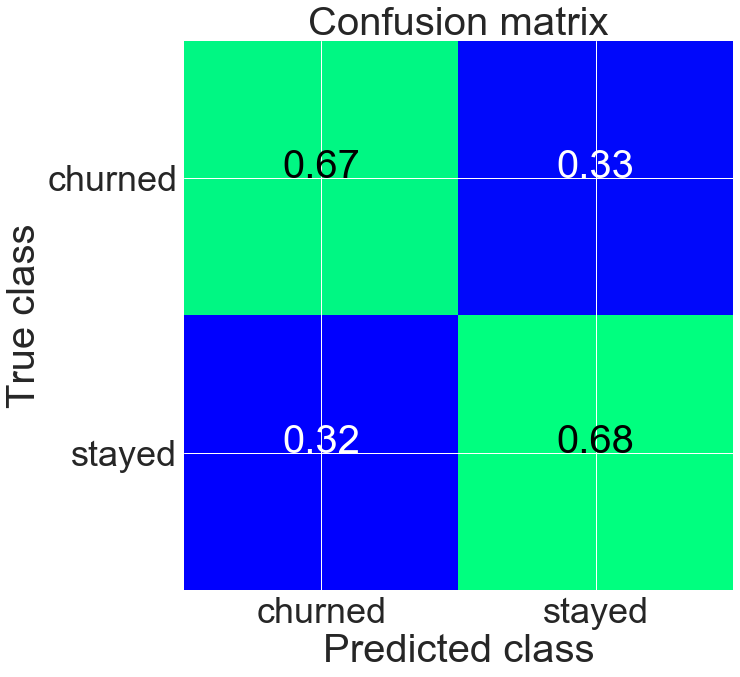

In [121]:
print("random forest performance on test set:\n")

y_predicted = rfmodel2.predict(X_test)
cm = confusion_matrix(y_test, y_predicted, labels = [0,1])
tp = cm[0][0]
fn = cm [0][1]
fp = cm [1][0]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
print "\nprecision= %4.2f, recall= %4.2f "%(precision, recall),'\n'

f = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['churned','stayed'], normalize=True, title='Confusion matrix')
plt.savefig('x.png')
plt.show()


### classify all users

random forest performance on the entire dataset:


precision= 0.68, recall= 0.67  



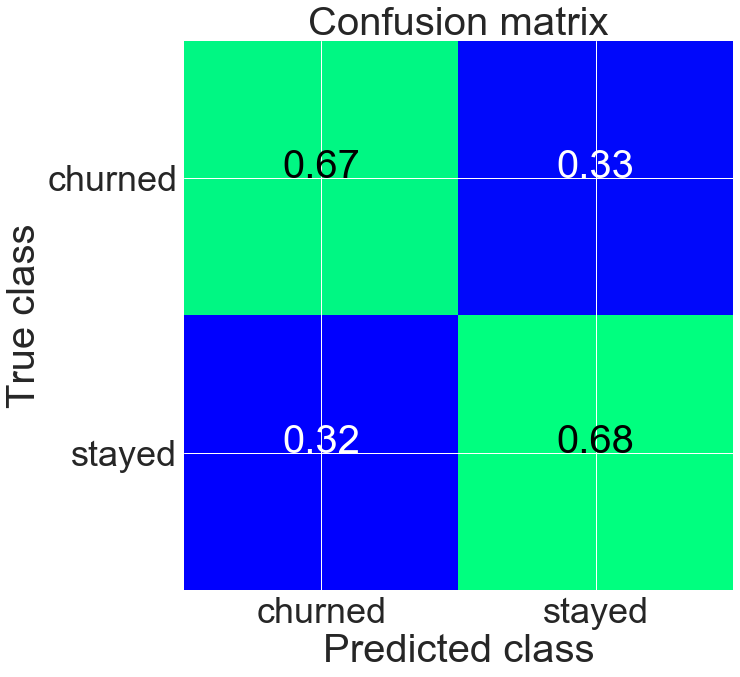

In [124]:
print("random forest performance on the entire dataset:\n")
y_predicted = rfmodel2.predict(df3_up.drop('churned',axis=1))
cm = confusion_matrix(df3_up.churned, y_predicted, labels = [0,1])
tp = cm[0][0]
fn = cm [0][1]
fp = cm [1][0]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
print "\nprecision= %4.2f, recall= %4.2f "%(precision, recall),'\n'

f = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['churned','stayed'], normalize=True, title='Confusion matrix')
plt.savefig('x.png')
plt.show()



### sidenote:
The classification threshold here is set at 0.5. If a user has a probability of >= 0.5 to churn, they are classified as will churn / has churned. Tuning the threshold can further vary/optimize the recall and precision score if needed.

## 2. Logistic regression classifier 
Logistic regression classifier  is a weaker performer than random forest, but serves well as a quick baseline check

In [127]:
lrmodel = LogisticRegression(C=1000000,random_state=108,solver='liblinear', 
                         multi_class='ovr')
l = lrmodel.fit(X_train, y_train)
y_predicted = lrmodel.predict(X_val)
print("logistic regression performance on validation set:\n")

cm = confusion_matrix(y_val, y_predicted, labels = [0,1])
tp = cm[0][0]
fn = cm [0][1]
fp = cm [1][0]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
print "\nprecision= %4.2f, recall= %4.2f "%(precision, recall),'\n'



logistic regression performance on validation set:


precision= 0.55, recall= 0.61  



logistic regression performance on test set:


precision= 0.57, recall= 0.61  



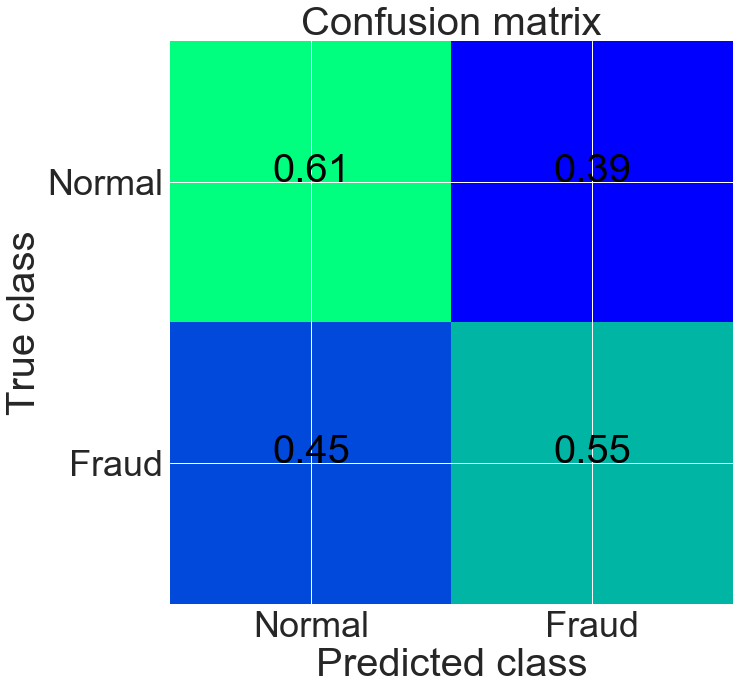

In [129]:
lrmodel = LogisticRegression(C=1000000,random_state=108,solver='liblinear', 
                         multi_class='ovr')
l = lrmodel.fit(X_train, y_train)
y_predicted = lrmodel.predict(X_test)
print("logistic regression performance on test set:\n")

cm = confusion_matrix(y_test, y_predicted, labels = [0,1])
tp = cm[0][0]
fn = cm [0][1]
fp = cm [1][0]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
print "\nprecision= %4.2f, recall= %4.2f "%(precision, recall),'\n'

f = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Normal','Fraud'], normalize=True, title='Confusion matrix')
plt.savefig('x.png')
plt.show()

In [130]:
# get important features for each class
importances = lrmodel.coef_[0]
features = list(df3.drop('churned',axis=1).columns)
df_lr = pd.DataFrame({'importances':importances,'features':features})
df_lr_f = df_lr[df_lr.importances>0.]
df_lr_n = df_lr[df_lr.importances<0.]
df_lr_normal = df_lr_n.sort_values(by=['importances'],ascending=True)
df_lr_not = df_lr_f.sort_values(by=['importances'],ascending=False)

# display top features and discussion
print("**top features for churned users:**")
print("in descending rank of importance")
df_lr_not.sort_values(by=['importances'],ascending=True).reset_index().drop(['index','importances'],axis=1).head(5)



print("\n\n**top features for users who didn't churn:**")
print("in descending rank of importance")
df_lr_normal.sort_values(by=['importances'],ascending=True).reset_index().drop(['index','importances'],axis=1).head(5)
print("\n The top features here are very different than what was selected by random forest previously. Since all features were included in the model regardless of their potential weight, random forest naturally performs better since it is good at \
selecting important features. Logistic regression is weaker at this task, and it can't select the best features to use.")

**top features for churned users:**
in descending rank of importance


,features
0,platform_both
1,instrument_type_first_traded_reit
2,instrument_type_first_traded_adr
3,instrument_type_first_traded_stock
4,instrument_type_first_traded_etp




**top features for users who didn't churn:**
in descending rank of importance


,features
0,instrument_type_first_traded_cef
1,instrument_type_first_traded_rlt
2,instrument_type_first_traded_tracking
3,risk_tolerance
4,platform_iOS



 The top features here are very different than what was selected by random forest previously. Since all features were included in the model regardless of their potential weight, random forest naturally performs better since it is good at selecting important features. Logistic regression is weaker at this task, and it can't select the best features to use.


### classify all users

logistic regression performance on the entire dataset:


precision= 0.58, recall= 0.61  



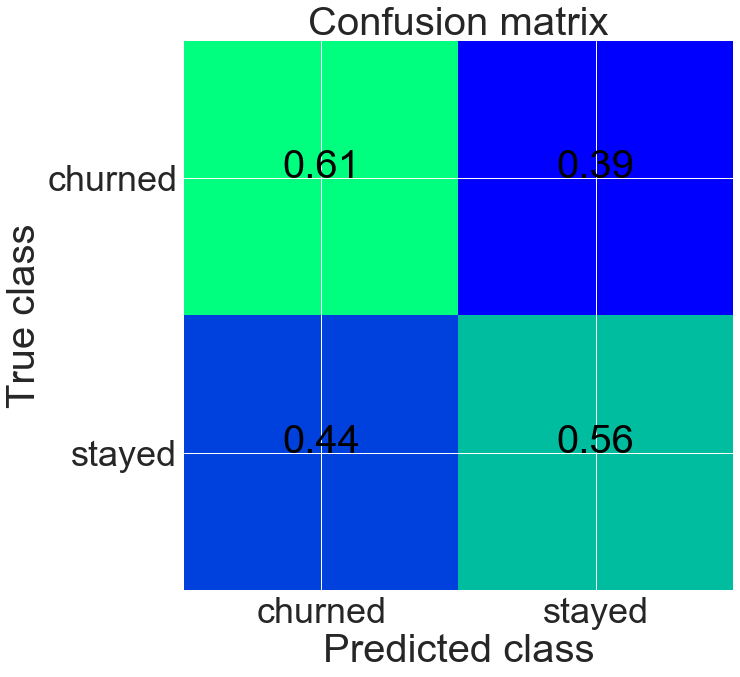

In [133]:
print("logistic regression performance on the entire dataset:\n")
y_predicted = lrmodel.predict(df3_up.drop('churned',axis=1))
cm = confusion_matrix(df3_up.churned, y_predicted, labels = [0,1])
tp = cm[0][0]
fn = cm [0][1]
fp = cm [1][0]
precision = float(tp)/(tp+fp)
recall = float(tp)/(tp+fn)
print "\nprecision= %4.2f, recall= %4.2f "%(precision, recall),'\n'

f = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['churned','stayed'], normalize=True, title='Confusion matrix')
plt.savefig('x.png')
plt.show()




# Project summary

• Analyzed 1 million entries of customer data in equity investment collected over 1 year. <br>
• Performed exploratory data analysis on churned customers<br>
• feature engineering: ordinal -> numerical, categorical -> one-hot encoded. <br>
• Upsampled churned customer data (4% of total) to address data imbalance.<br>
• Tuned random forest to obtain best recall score, and used logistic regression as baseline comparison.<br>
• Discovered meaningful insight from feature importance: target customers with limited or no investment experience and high risk tolerance to lower churn rate.

# Conclusion

This data analysis unveiled that customer churn rate is higher for the group with limited or no investment experience. The data suggested that providing assistance for customers with less investment experience can effectively decrease customer churn / increase customer retention.  Customer churn rate is also higher for the group with higher risk tolerance. When customers take higher risks, they may panic and sell at the wrong time, which in turn them to churn. From the data, high risk tolerance is correlated with investment experience. This reierate again on the importance of providing further assistance for customers with less investment experience.